# Teoria da Decisão - ELE088

*Prof. Lucas S. Batista*  
*Departamento de Engenharia Elétrica*  
*Universidade Federal de Minas Gerais* 

# Estudo de Caso

## Problema de Designação Simples:

- Considere que existem $n$ tarefas e $n$ agentes, de tal forma que cada tarefa deve ser atribuída a um único agente e cada agente só pode receber uma tarefa. A execução da tarefa $j$ pelo agente $i$ tem um custo $c_{ij}$. Formule um problema que atribua as tarefas de forma a minimizar o custo total de execução. 

## Modelagem do problema

Assumindo que $x_{ij}$ represente as variáveis de otimização do problema, pode-se definir que se $x_{ij} = 1$, então a tarefa $j$ é atribuída ao agente $i$; caso contrário, i.e., se $x_{ij} = 0$, então a tarefa $j$ não é atribuída ao agente $i$.

Com o intúito de minimizar o custo total de execução de todas as tarefas, pode-se escrever a seguinte função objetivo:

$$ \min_x \sum_{i=1}^{n} \sum_{j=1}^{n} c_{ij} x_{ij} $$

Adicionalmente, este problema apresenta o seguinte conjunto de restrições:

\begin{align} 
\sum_{j=1}^{n} x_{ij} = 1, \forall i \in \{1, \ldots, n\} \hspace{2cm} (R1) \\
\sum_{i=1}^{n} x_{ij} = 1, \forall j \in \{1, \ldots, n\} \hspace{2cm} (R2) \\
x_{ij} \in \{0, 1\}, \forall i \in \{1, \ldots, n\}, \forall j \in \{1, \ldots, n\} \hspace{2cm} (R3)
\end{align}

em que **R1** assegura que cada agente $i$ executará uma única tarefa $j$; **R2** assegura que cada tarefa $j$ será realizada por um único agente $i$; e **R3** define o domínio das variáveis de decisão $x_{ij}$.

## Otimização de uma instância arbitrária do problema via RVNS

A seguir são apresentados os trechos de código da implementação do RVNS para o estudo de caso apresentado.

In [ ]:
'''
Importa os módulos usados
'''
import numpy as np
import matplotlib.pyplot as plt
import copy

'''
Define um tipo de dado similar ao Pascal "record" or C "struct"
'''
class Struct:
    pass

Os dados da instância teste são definidos a seguir. Note que considera-se um número de agentes/tarefas *default* $n=50$. Além disso, assume-se uma matriz de custos $c_{ij}$ em que os custos de execução das tarefas $t_1, t_2, \ldots, t_j, \ldots, t_n$ pelo $i$-ésimo agente são apresentados ao longo da $i$-ésima linha.

In [ ]:
'''
Define os dados de uma instância arbitrária do problema
'''
def probdef(n=50):
    
    # n: número de tarefas/agentes considerados
        
    '''
    Matriz de custo: c = [  t1 t2 ... tj ... tn
                          a1
                          a2
                          ...
                          ai
                          ...
                          an                    ]
    ''' 
    
    np.random.seed(13)    
    c = np.random.randint(1,100,size=(n,n)) # considera custos inteiros aleatórios no conjunto {1, 2, ..., 99}
    np.random.seed()
    
    probdata = Struct()
    probdata.n = n
    probdata.c = c
        
    return probdata

Uma solução candidata $x$ para o problema foi modelada computacionalmente como a sequência de tarefas atribuídas, respectivamente, aos agentes $a_1, a_2, ... a_i, ..., a_n$.

In [ ]:
'''
Implementa uma solução inicial para o problema
'''
def sol_inicial(probdata,apply_constructive_heuristic):
    
    '''  
    Modelou-se uma solução x como a sequência de tarefas atribuídas, respectivamente, aos agentes a1, a2, ... ai, ..., an
    
         a1 a2 ... an
    x = [t7 t3 ... t9]
    '''
    
    if apply_constructive_heuristic == False:        
        # Constrói solução inicial aleatoriamente
        x = Struct()
        x.solution = list(np.random.permutation(probdata.n))
    
    else:
        # Constrói solução inicial usando uma heurística construtiva
        x = Struct()
        x.solution = []
        job = np.argsort(probdata.c.var(axis=0))    # tarefas ordenadas de acordo com a variância dos custos
        for tarefa in job[::-1]:        
            agent = np.argmin(probdata.c[:,tarefa]) # atribui as tarefas em ordem decrescente de variância ao agente de menor custo
            x.solution.insert(agent,tarefa)
        
    return x

A função objetivo é implementada conforme a definição apresentada anteriormente. De forma geral, dada uma solução $x$, que indica a distribuição de tarefas a agentes, esta função computa o somatório dos custos relacionados.

In [ ]:
'''
Implementa a função objetivo do problema
'''
def fobj(x, probdata):
    
    '''
         a1 a2 ... an
    x = [t7 t3 ... t9]
    '''
    
    fitness = 0.0
    for i in np.arange(0,probdata.n,1):
        fitness += probdata.c[i,x.solution[i]]
    
    x.fitness = fitness
    return x

A função *neighborhoodChange* atualiza a solução corrente e também a estrutura de vizinhança. De forma geral, se a nova solução gerada $y$ apresentar um custo *fitness_y* menor que o da solução incumbente $x$, então a solução incumbente é atualizada e retoma-se a primeira estrutura de vizinhança, i.e., faz-se $k = 1$. Caso contrário, apenas segue-se para a próxima estrutura de vizinhança, mantendo-se a solução corrente $x$.

In [ ]:
'''
Implementa a função neighborhoodChange
'''
def neighborhoodChange(x, y, k):
    
    if y.fitness < x.fitness:
        x = copy.deepcopy(y)
        k = 1
    else:
        k += 1
        
    return x, k

Para o estudo de caso em questão foram propostas três estruturas de vizinhanças:

1. A primeira estrutura de vizinhança realiza a troca da atribuição de duas tarefas entre agentes escolhidos arbitrariamente.
2. A segunda estrutura de vizinhança é semelhante à primeira, porém envolve a troca de três tarefas.
3. A terceira estrutura de vizinhança realiza o deslocamente de tarefas entre um conjunto de agentes.

In [ ]:
'''
Implementa a função shake
'''
def shake(x, k, probdata):
        
    y = copy.deepcopy(x)
    r = np.random.permutation(probdata.n)
    
    if k == 1:             # exchange two random positions
        y.solution[r[0]] = x.solution[r[1]]
        y.solution[r[1]] = x.solution[r[0]]        
    elif k == 2:           # exchange three random positions
        y.solution[r[0]] = x.solution[r[1]]
        y.solution[r[1]] = x.solution[r[2]]
        y.solution[r[2]] = x.solution[r[0]]
    elif k == 3:           # shift positions     
        z = y.solution.pop(r[0])
        y.solution.insert(r[1],z)
    
    return y

### Estrutura principal do método RVNS


--- SOLUÇÃO INICIAL CONSTRUÍDA ---

Sequência de tarefas atribuídas aos agentes:

x = [36, 39, 32, 18, 2, 41, 9, 17, 46, 12, 43, 35, 3, 4, 10, 30, 15, 48, 42, 44, 8, 1, 6, 31, 22, 29, 37, 0, 5, 25, 14, 20, 11, 47, 23, 16, 38, 7, 33, 45, 21, 49, 34, 19, 28, 27, 13, 26, 24, 40]

fitness(x) = 2252.0


--- MELHOR SOLUÇÃO ENCONTRADA ---

Sequência de tarefas atribuídas aos agentes:

x = [28, 14, 24, 34, 9, 2, 5, 31, 35, 20, 41, 17, 36, 21, 29, 7, 16, 37, 8, 19, 30, 46, 38, 22, 26, 12, 49, 0, 23, 6, 4, 13, 11, 39, 1, 43, 10, 27, 40, 33, 15, 48, 45, 44, 25, 47, 32, 3, 42, 18]

fitness(x) = 301.0



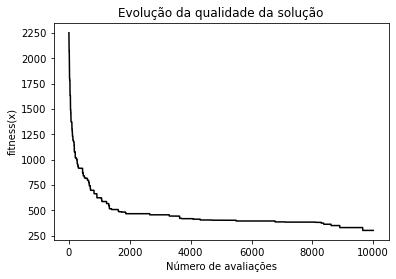

In [ ]:
'''
Implementa uma metaheurística RVNS
'''

# Contador do número de soluções candidatas avaliadas
num_sol_avaliadas = 0

# Máximo número de soluções candidatas avaliadas
max_num_sol_avaliadas = 10000

# Número de estruturas de vizinhanças definidas
kmax = 3

# Faz a leitura dos dados da instância do problema
probdata = probdef(n=50)

# Gera solução inicial
x = sol_inicial(probdata,apply_constructive_heuristic=False)

# Avalia solução inicial
x = fobj(x,probdata)
num_sol_avaliadas += 1

# Armazena dados para plot
historico = Struct()
historico.sol = []
historico.fit = []
historico.sol.append(x.solution)
historico.fit.append(x.fitness)


# Ciclo iterativo do método
while num_sol_avaliadas < max_num_sol_avaliadas:
    
    k = 1
    while k <= kmax:
        
        # Gera uma solução candidata na k-ésima vizinhança de x        
        y = shake(x,k,probdata)
        y = fobj(y,probdata)
        num_sol_avaliadas += 1
        
        # Atualiza solução corrente e estrutura de vizinhança (se necessário)
        x,k = neighborhoodChange(x,y,k)
        
        # Armazena dados para plot
        historico.sol.append(x.solution)
        historico.fit.append(x.fitness)


print('\n--- SOLUÇÃO INICIAL CONSTRUÍDA ---\n')
print('Sequência de tarefas atribuídas aos agentes:\n')
print('x = {}\n'.format(historico.sol[0]))
print('fitness(x) = {:.1f}\n'.format(historico.fit[0]))

print('\n--- MELHOR SOLUÇÃO ENCONTRADA ---\n')
print('Sequência de tarefas atribuídas aos agentes:\n')
print('x = {}\n'.format(x.solution))
print('fitness(x) = {:.1f}\n'.format(x.fitness))

plt.figure()
s = len(historico.fit)
plt.plot(np.linspace(0,s-1,s),historico.fit,'k-')
plt.title('Evolução da qualidade da solução');
plt.xlabel('Número de avaliações');
plt.ylabel('fitness(x)');
plt.show()